# Import librairies et jeux de données

In [23]:
import pandas as pd
import numpy as np

#pour les représentations graphiques
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

#pour centrer-réduire
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#pour les test statistiques
from scipy.stats import ttest_ind, shapiro

#pour les modèles non-supervisés
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#pour les modèles supervisés
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold

#Pour évaluer les performances des modèles
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_percentage_error, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from scipy.optimize import linear_sum_assignment
from sklearn.model_selection import cross_val_score

In [2]:
df_scaled = pd.read_csv("df_scaled_StandardScaler.csv", sep=',')
df = pd.read_csv("df.csv", sep=',')

In [3]:
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


## Application du Kmeans

In [4]:
#on supprime la colonne is_genuine
df_kmeans = df_scaled.drop(columns='is_genuine')
df_kmeans.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.486540,2.774123,3.163240,0.056440,-1.128325,0.173651
1,-1.633729,-2.236535,-0.799668,-1.080592,-0.696799,0.471666
2,2.397823,1.504756,-1.291191,-0.125486,-0.912562,0.551901
3,-1.961498,-0.399294,0.060498,-1.307998,-0.610494,0.953075
4,-0.748754,0.836669,-1.414072,-0.671261,1.417677,-0.158750


Sachant que l'on cherche à dvisier nos individus selon 2 modalités (vrai/faux billet), j'effectue mon kmeans pour 2 clusters.

In [5]:
# On instancie notre Kmeans avec 2 clusters : 
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)

# On l'entraine : 
kmeans.fit(df_kmeans)

# On peut stocker nos clusters dans une variable labels : 
labels = kmeans.labels_
labels

array([1, 0, 0, ..., 1, 1, 1])

In [6]:
#creer une colonne pour mettre les clusters generés et ré-intégrer la colonne is_genuine
df_kmeans['label_kmeans'] = labels
df_kmeans['is_genuine'] = df['is_genuine']
df_kmeans.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,label_kmeans,is_genuine
0,-0.486540,2.774123,3.163240,0.056440,-1.128325,0.173651,1,1
1,-1.633729,-2.236535,-0.799668,-1.080592,-0.696799,0.471666,0,1
2,2.397823,1.504756,-1.291191,-0.125486,-0.912562,0.551901,0,1
3,-1.961498,-0.399294,0.060498,-1.307998,-0.610494,0.953075,0,1
4,-0.748754,0.836669,-1.414072,-0.671261,1.417677,-0.158750,0,1


In [7]:
df_kmeans['label_kmeans'].value_counts()

0    1004
1     496
Name: label_kmeans, dtype: int64

## Tableau de contingence

A cette étape, nous voulons nous assurer que chaque cluster obtenu avec le kmeans correspond bien à la même catégorie de la colonne is_genuine.

In [8]:
#Création des listes de clusters
list_label_is_genuine = list(int(label) for label in df_kmeans['is_genuine'])
list_label_kmeans = list(int(label) for label in df_kmeans['label_kmeans'])

In [9]:
# Je crée une matrice de confusion entre les deux clusterings
conf_mat = confusion_matrix(list_label_is_genuine, list_label_kmeans)

# Je cherche l’appariement optimal
row_ind, col_ind = linear_sum_assignment(-conf_mat)  # le "-" car c'est un problème de maximisation

# Je crée un mapping entre les labels
label_mapping = {col: row for row, col in zip(row_ind, col_ind)}

# Je recalibre les labels KMeans
aligned_kmeans_labels = np.array([label_mapping[label] for label in list_label_kmeans])

#j'attribue les nouveaux clusters
df_kmeans['label_kmeans'] = aligned_kmeans_labels

In [10]:
df_kmeans['label_kmeans'].value_counts()

1    1004
0     496
Name: label_kmeans, dtype: int64

In [11]:
y_pred = df_kmeans['label_kmeans'].astype(int)
y_true = df_kmeans['is_genuine'].astype(int)

# Puis affiche la matrice
cm = confusion_matrix(y_true, y_pred)
cm

array([[486,  14],
       [ 10, 990]], dtype=int64)

## Calcul des centroïdes

In [12]:
df_kmeans.drop(columns='is_genuine', inplace=True)
mean_values_kmeans = df_kmeans.groupby('label_kmeans').mean()
mean_values_kmeans

,diagonal,height_left,height_right,margin_low,margin_up,length
label_kmeans,,,,,,
0,-0.194323,0.570713,0.713365,1.120167,0.864176,-1.200833
1,0.096000,-0.281946,-0.352419,-0.553389,-0.426924,0.593240


## Exemple avec un nouveau billet

In [20]:
nouveau_billet = np.array([[0.01, -0.28, -0.35, -0.55, - 0.43, 0.59]])

In [21]:
# Prédiction du cluster
cluster = kmeans.predict(nouveau_billet)

C:\Users\Pauline NANDELEC\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


In [22]:
cluster

array([0])

Sachant que lors de l'entrainement de Kmeans, 0 correspondant aux vrais billets et 1 aux faux billets, ce billet est vrai.

# Régression logistique

In [16]:
df_scaled.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,-0.486540,2.774123,3.163240,0.056440,-1.128325,0.173651
1,1,-1.633729,-2.236535,-0.799668,-1.080592,-0.696799,0.471666
2,1,2.397823,1.504756,-1.291191,-0.125486,-0.912562,0.551901
3,1,-1.961498,-0.399294,0.060498,-1.307998,-0.610494,0.953075
4,1,-0.748754,0.836669,-1.414072,-0.671261,1.417677,-0.158750


In [17]:
df_scaled.loc[df_scaled['is_genuine'] == 0].head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1000,0,1.053972,-0.265676,-0.031662,0.450610,0.684084,-1.465432
1001,0,-0.125994,-0.566316,1.166426,0.723498,-0.092663,-1.591516
1002,0,-1.207630,0.369007,1.412188,0.738658,1.374525,-1.671750
1003,0,0.201774,1.003691,1.258587,1.072188,0.252558,-0.789167
1004,0,1.938947,0.736455,0.951385,1.693765,-0.092663,-1.098644


In [18]:
#définition X et y
X = df_scaled.drop(columns='is_genuine').to_numpy()
y = df_scaled['is_genuine'].to_numpy()

doit-on justifier à cette étape pourquoi on utilise toutes les variables y et non pas une sélection ?

## Test des hypothèses de la régression logistique

## Validation croisée

La répartition arbitraire des échantillons en sous-ensembles de test et d'entraînement peut être problématique si leur caractéristique statistique diverge fortement entre les 2 sous-ensembles. La validation croisée permet de contrer ce problème.

In [24]:
# Initialisation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#Remarque: en choisissant n_splits=5, la répartition est la suivante : 80% train / 20% test
model = LogisticRegression(max_iter=1000)

best_score = 0
best_split = None

for fold_idx, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #Comme on cherche ici a minimiser le nombre de faux positifs, la métrique la plus adaptée est precision
    score = precision_score(y_test, y_pred)

    print(f"Fold {fold_idx} : Precision = {score:.4f}")

    if score > best_score:
        best_score = score
        best_split = (train_index, test_index)

Fold 0 : Precision = 0.9950
Fold 1 : Precision = 0.9900
Fold 2 : Precision = 0.9901
Fold 3 : Precision = 0.9950
Fold 4 : Precision = 0.9900


In [25]:
# Récupération des données associées à la meilleure partition
train_index, test_index = best_split
X_best_train, X_best_test = X[train_index], X[test_index]
y_best_train, y_best_test = y[train_index], y[test_index]

## Entraînement du modèle

In [26]:
#initialisation et entraînement du modèle
clf = LogisticRegression(random_state=808).fit(X_best_train, y_best_train)

In [27]:
# Prediction d'un échantillon
print("Prédiction",clf.predict([X[1000, :]])[0])

print("Probabilité",clf.predict_proba([X[1000, :]])[0][0])

Prédiction 0
Probabilité 0.9965656971368685


Soit 83.10 % de chance d'appartenir à la classe 0.

In [28]:
print("Classe réelle du billet: ", y[1000])

Classe réelle du billet:  0


In [29]:
# Prediction d'un échantillon
print("Prédiction",clf.predict([X[0, :]])[0])

print("Probabilité",clf.predict_proba([X[0, :]])[0][0])

Prédiction 1
Probabilité 0.30188803673683595


Soit 58.71 % de chance d'appartenir à la classe 0.

In [30]:
print("Classe réelle du billet: ", y[0])

Classe réelle du billet:  1


## Mesures de perfomance

<Axes: ylabel='Count'>

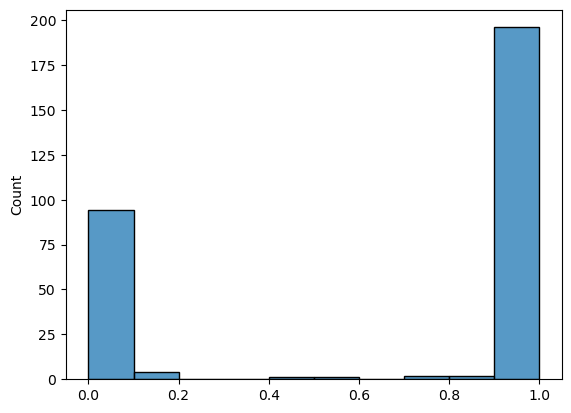

In [31]:
#histogramme des probabilités de prédiction
y_hat_proba = clf.predict_proba(X_best_test)[:,1]
sns.histplot(y_hat_proba)

Le modèle est assez confiant de ses prédiction, la plupart des prédictions ont une probabilité proche de 0 ou de 1

In [32]:
#Accuracy 
y_pred = clf.predict(X_best_test)

print("accuracy",accuracy_score(y_best_test, y_pred))

accuracy 0.9966666666666667


L'accuracy mesure le nombre d'échantillons qui ont été bien classés sur le nombre d'échantillons total. 99.7% est un très bon score.

In [34]:
#matrice de confusion

confusion_matrix(y_best_test, y_pred)

array([[ 99,   1],
       [  0, 200]], dtype=int64)

1 faux positifs (faux billets classés comme vrais billets)

## Test avec d'autres seuils de classification

Dans le cas de la détection de fraude, il y a un fort déséquilibre entre les cas positifs et les cas négatifs dans le dataset.
On obtient ici une accuracy de 98.7% mais il faut faire intervenir d'autres métriques de classification adaptées à ce type de situation pour adapter notre modèle.

In [35]:
y_hat_proba = clf.predict_proba(X_best_test)[:,1]

In [36]:
#On obtient les catégories relatives pour les 2 seuils :
y_pred_03 = [ 0 if value < 0.3 else 1 for value in y_hat_proba ]
y_pred_07 = [ 0 if value < 0.7 else 1 for value in y_hat_proba ]

In [37]:
#On a alors les matrices de confusion suivantes :

#pour 0.3:
confusion_matrix(y_test, y_pred_03)

array([[ 98,   2],
       [  0, 200]], dtype=int64)

5 faux positifs (faux billets classés comme vrais billets)

In [38]:
#pour 0.7:
confusion_matrix(y_best_test, y_pred_07)

array([[ 99,   1],
       [  1, 199]], dtype=int64)

1 faux positif (faux billet classé comme vrai) et 3 faux négatifs (vrais billets classés comme faux)

In [39]:
#Autres métriques de classification
print("Accuracy:",accuracy_score(y_best_test, y_pred))
print("Precision:",precision_score(y_best_test, y_pred))
print("Recall:",recall_score(y_best_test, y_pred))

Accuracy: 0.9966666666666667
Precision: 0.9950248756218906
Recall: 1.0


In [40]:
print("Accuracy:",accuracy_score(y_best_test, y_pred_03))
print("Precision:",precision_score(y_best_test, y_pred_03))
print("Recall:",recall_score(y_best_test, y_pred_03))

Accuracy: 0.9933333333333333
Precision: 0.9900990099009901
Recall: 1.0


In [41]:
print("Accuracy:",accuracy_score(y_best_test, y_pred_07))
print("Precision:",precision_score(y_best_test, y_pred_07))
print("Recall:",recall_score(y_best_test, y_pred_07))

Accuracy: 0.9933333333333333
Precision: 0.995
Recall: 0.995


Text(0.5, 1.0, 'ROC curve 0.5')

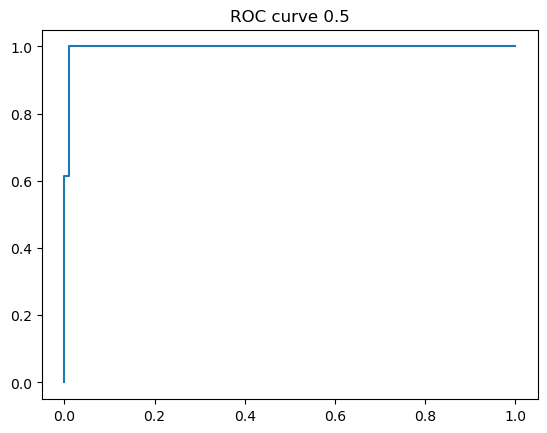

In [42]:
#On peut tracer la courbe ROC pour visualiser cela.

#Pour seuil de classification = 0.5
fpr, tpr, thresholds = roc_curve(y_best_test, y_hat_proba)
plt.plot(fpr, tpr)
plt.title("ROC curve 0.5")

Text(0.5, 1.0, 'ROC curve 0.3')

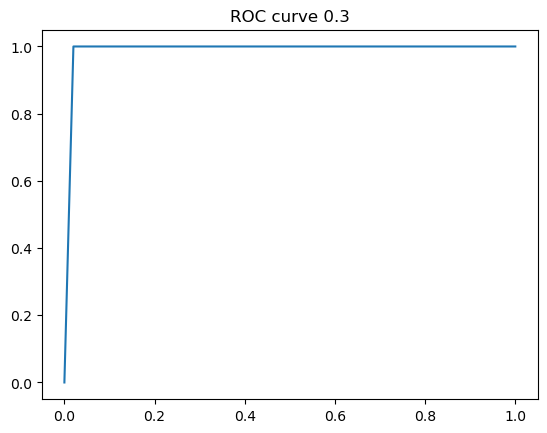

In [43]:
#Pour seuil de classification = 0.3
fpr, tpr, thresholds = roc_curve(y_best_test, y_pred_03)
plt.plot(fpr, tpr)
plt.title("ROC curve 0.3")

Text(0.5, 1.0, 'ROC curve 0.7')

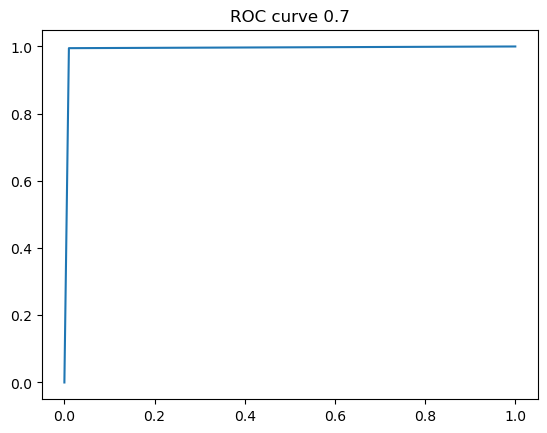

In [44]:
#Pour seuil de classification = 0.7
fpr, tpr, thresholds = roc_curve(y_best_test, y_pred_07)
plt.plot(fpr, tpr)
plt.title("ROC curve 0.7")

"Plus la courbe se rapproche du coin en haut à gauche, meilleur est le modèle.": le meilleur modèle est donc celui avec le seuil de classification 0.5 ou 0.7